# Mapping long-term changes in the annual water extent of the Okavango Delta

* **Products used:** 
[wofs_ls_summary_annual](https://explorer.digitalearth.africa/products/wofs_ls),

## Description

The notebook demonstrates how to load, visualise, and analyse the [WOfS annual summary](https://docs.digitalearthafrica.org/en/latest/data_specs/Landsat_WOfS_specs.html) product to gather insights into the longer-term extent of the Okavango delta.

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import map_shapefile, xr_animation
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:46095 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app='water_extent')

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

The parameters are:

* `vector_file`: The path to the shapefile or geojson that will define the analysis area of the study
* `start_year` and `end_year`: The date range to analyse (e.g. `('1990', '2020')`.


In [4]:
# Define the area of interest
vector_file = 'data/okavango_delta_outline.geojson'

# Define the start year and end year
start_year = '1990'
end_year = '2020'

## View the vector data of Interest on an interactive map


In [5]:
#read shapefile
gdf = gpd.read_file(vector_file)

# map_shapefile(gdf, attribute='GRID_CODE')

## Load WOfS annual summaries


In [6]:
#Create a query object
bbox=list(gdf.total_bounds)
lon_range = (bbox[0], bbox[2])
lat_range = (bbox[1], bbox[3])

query = {
    'x': lon_range,
    'y': lat_range,
    'resolution': (-30, 30),
    'output_crs':'EPSG:6933',
    'time': (start_year, end_year),
    'dask_chunks':dict(x=1000,y=1000)
}

#load wofs
ds = dc.load(product="wofs_ls_summary_annual",
             **query)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 31, x: 6955, y: 7774)
Coordinates:
  * time         (time) datetime64[ns] 1990-07-02T11:59:59.999999 ... 2020-07...
  * y            (y) float64 -2.279e+06 -2.279e+06 ... -2.512e+06 -2.513e+06
  * x            (x) float64 2.097e+06 2.097e+06 ... 2.305e+06 2.305e+06
    spatial_ref  int32 6933
Data variables:
    count_wet    (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    count_clear  (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    frequency    (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [7]:
#create mask
mask = xr_rasterize(gdf,ds)

#mask data
ds = ds.where(mask)

## Animating time series
In the next cell, we plot the dataset we loaded above as an animation GIF, using the [`xr_animation`](../Frequently_used_code/Animated_timeseries.ipynb) function.
The `output_path` will be saved in the directory where the script is found and you can change the names to prevent files overwrite.

Exporting animation to results/okavango_annual_water_frequency.gif


  0%|          | 0/31 (0.0 seconds remaining at ? frames/s)

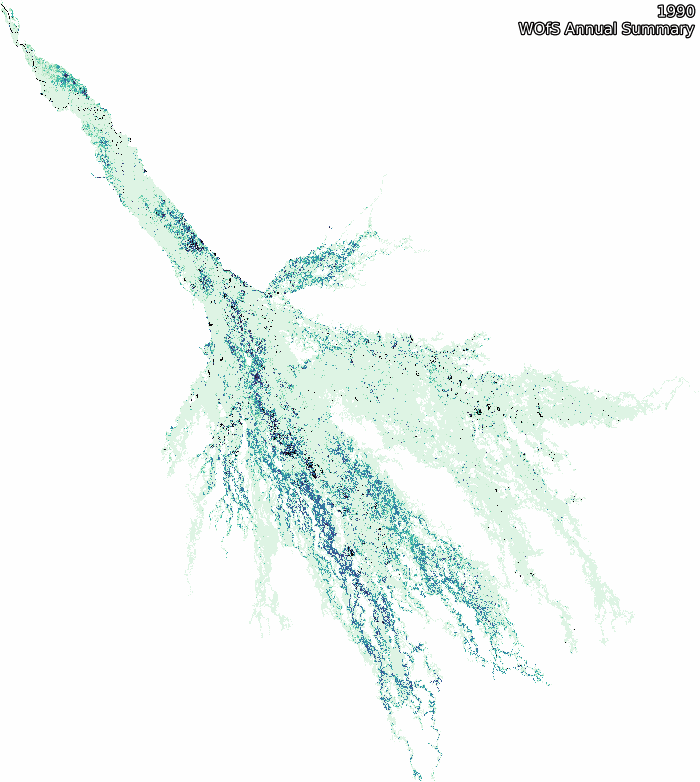

In [8]:
out_path = 'results/okavango_annual_water_frequency.gif'

xr_animation(ds=ds, 
             output_path=out_path,
             interval=400,
             bands=['frequency'], 
             show_text='WOfS Annual Summary', 
             show_date = '%Y',
             width_pixels=700,
             annotation_kwargs={'fontsize': 15},
             imshow_kwargs={'cmap': sns.color_palette("mako_r", as_cmap=True), 'vmin': 0.0, 'vmax': 0.9},
             colorbar_kwargs={'colors': 'black'},
             show_colorbar=False) 

# Plot animated gif
plt.close()
Image(filename=out_path)

## Calculate the annual area of water extent

The number of pixels can be used for the area of the waterbody if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [9]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

### Threshold WOfS annual frequency to classify water/not-water

Calculates the area of pixels classified as water (i.e. if `ds.frequency` is > 0.1, then the pixel will be considered open water during the year)

In [10]:
water_threshold = 0.1

In [11]:
#threshold
water_extent = (ds.frequency > water_threshold).persist()


#calculate area
ds_valid_water_area = water_extent.sum(dim=['x', 'y']) * area_per_pixel

### Plot the annual area of open water

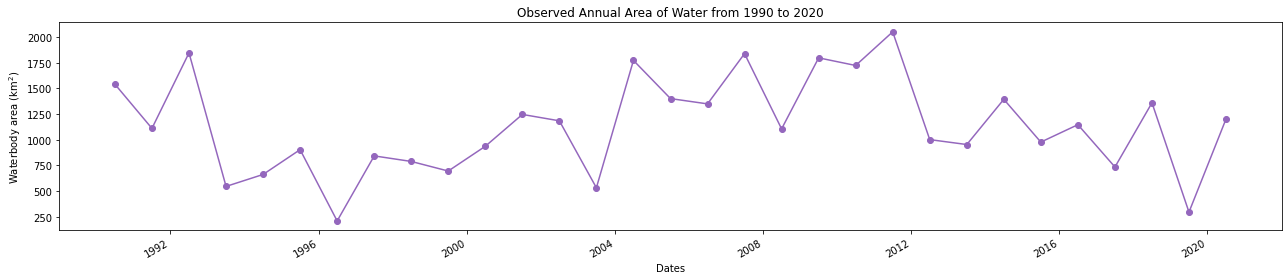

In [12]:
plt.figure(figsize=(18, 4))
ds_valid_water_area.plot(marker='o', color='#9467bd')
plt.title(f'Observed Annual Area of Water from {start_year} to {end_year}')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()

## Determine minimum and maximum water extent
The next cell extract the Minimum and Maximum extent of water from the dataset using the `min` and `max` functions, we then add the dates to an `xarray.DataArray`.

In [13]:
min_water_area_date, max_water_area_date =  min(ds_valid_water_area), max(ds_valid_water_area)
time_xr = xr.DataArray([min_water_area_date.time.values, max_water_area_date.time.values], dims=["time"])

print(time_xr)

<xarray.DataArray (time: 2)>
array(['1996-07-01T23:59:59.999999000', '2011-07-02T11:59:59.999999000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: time


### Plot the dates when the min and max water extent occur
Plot water classified pixel for the two dates where we have the minimum and maximum surface water extent.

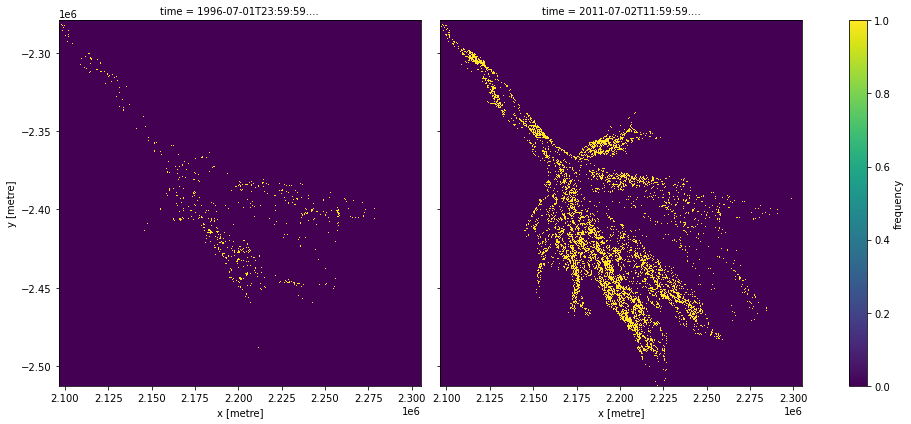

In [14]:
water_extent.sel(time=time_xr).plot.imshow(col="time", col_wrap=2, figsize=(14, 6));

## Compare two time periods
The following cells determine the maximum extent of water for two different years. 
* `baseline_year` : The baseline year for the analysis
* `analysis_year` : The year to compare to the baseline year

In [15]:
baseline_time = '2019'
analysis_time = '2020'

baseline_ds, analysis_ds = ds_valid_water_area.sel(time=baseline_time, method ='nearest'), ds_valid_water_area.sel(time=analysis_time, method ='nearest')

### Plotting

Plot water extent for the two chosen periods.

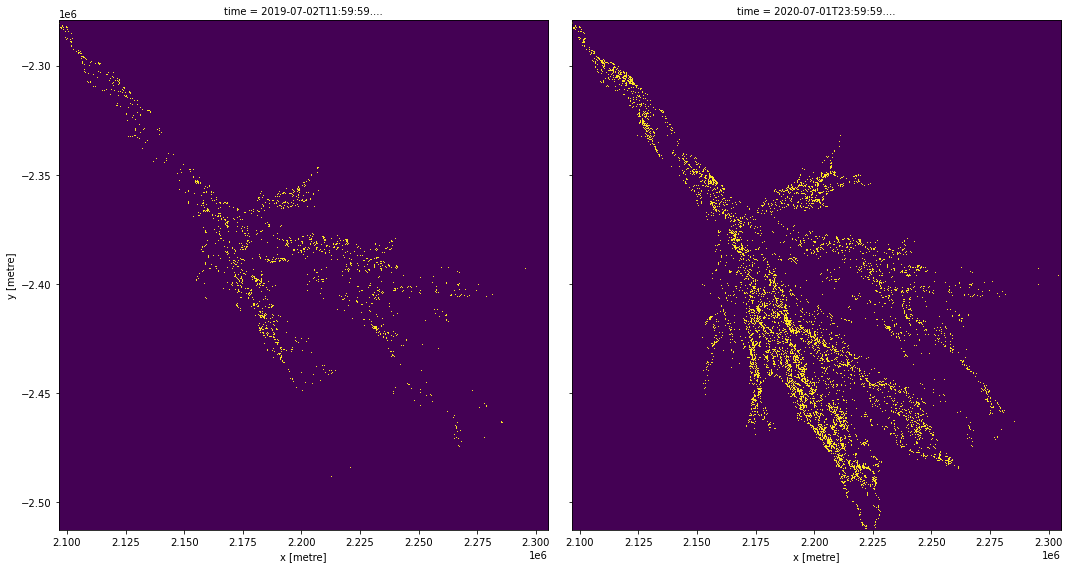

In [16]:
compare = water_extent.sel(time=[baseline_ds.time.values[0], analysis_ds.time.values[0]])

compare.plot.imshow(col="time",col_wrap=2,figsize=(15, 8), cmap='viridis', add_colorbar=False);

## Calculating the change for the two nominated periods
The cells below calculate the amount of water gain, loss and stable for the two periods

In [17]:
analyse_total_value = compare.isel(time=1).astype(int)
change = analyse_total_value - compare.isel(time=0).astype(int)

water_appeared = change.where(change == 1)
permanent_water = change.where((change == 0) & (analyse_total_value == 1))
permanent_land = change.where((change == 0) & (analyse_total_value == 0))
water_disappeared = change.where(change == -1)



The cell below calculate the area of water extent for water_loss, water_gain, permanent water and land 

In [18]:
total_area = analyse_total_value.count().values * area_per_pixel
water_apperaed_area = water_appeared.count().values * area_per_pixel
permanent_water_area = permanent_water.count().values * area_per_pixel
water_disappeared_area = water_disappeared.count().values * area_per_pixel

## Plotting
The water variables are plotted to visualised the result

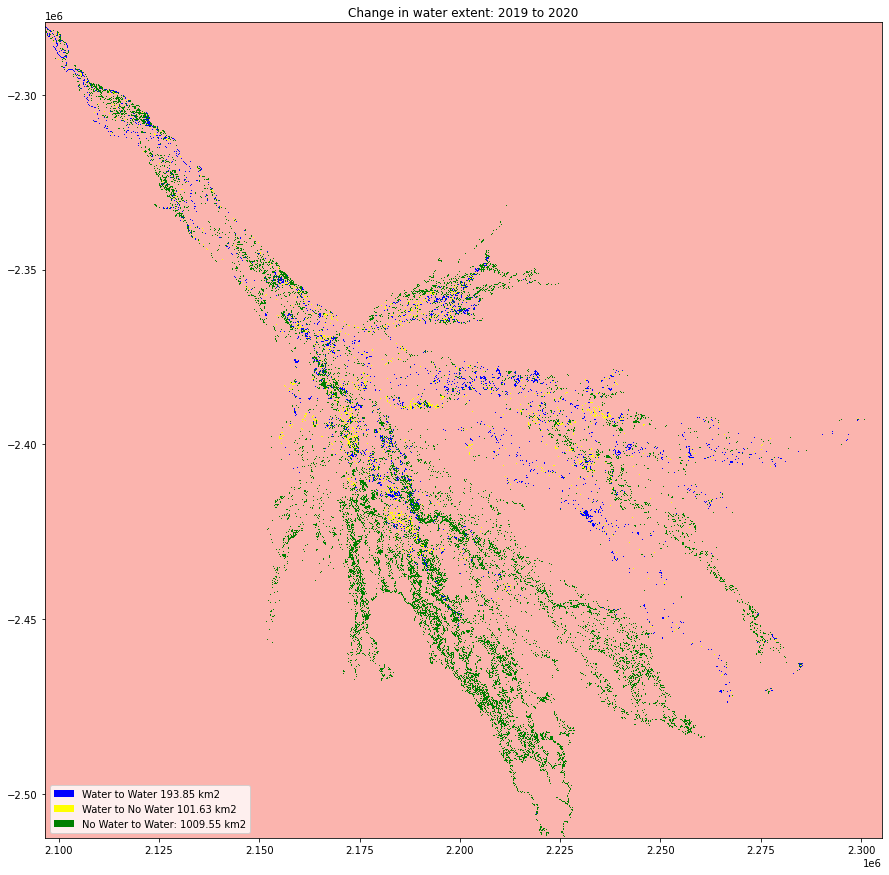

In [19]:
water_appeared_color = "Green"
water_disappeared_color = "Yellow"
stable_color = "Blue"
land_color = "Brown"

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

compare[1].plot.imshow(cmap="Pastel1",
                                       add_colorbar=False,
                                       add_labels=False,
                                       ax=ax)
water_appeared.plot.imshow(
    cmap=ListedColormap([water_appeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
water_disappeared.plot.imshow(
    cmap=ListedColormap([water_disappeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
permanent_water.plot.imshow(cmap=ListedColormap([stable_color]),
                            add_colorbar=False,
                            add_labels=False,
                            ax=ax)

plt.legend(
    [
        Patch(facecolor=stable_color),
        Patch(facecolor=water_disappeared_color),
        Patch(facecolor=water_appeared_color),
        Patch(facecolor=land_color),
    ],
    [
        f"Water to Water {round(permanent_water_area, 2)} km2",
        f"Water to No Water {round(water_disappeared_area, 2)} km2",
        f"No Water to Water: {round(water_apperaed_area, 2)} km2",
    ],
    loc="lower left",
)

plt.title("Change in water extent: " + baseline_time + " to " + analysis_time);

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [20]:
print(datacube.__version__)

1.8.5


**Last Tested:**

In [21]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-09-28'